In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from skimage import io
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
image = io.imread('1colour.jpg')
h, w, c = image.shape

X_coords, Y_coords = np.meshgrid(np.arange(h), np.arange(w))
coords = np.stack([X_coords.ravel(), Y_coords.ravel()], axis=-1)  
pixels = image.reshape(-1, 3) 

In [4]:
import torch

In [5]:
def random_fourier_features(coords, num_features, gamma=0.1):
    np.random.seed(0) 
    
    W = np.random.randn(2, num_features) * gamma
    b = 2 * np.pi * np.random.rand(num_features)
   
    fourier_features = np.cos(np.dot(coords, W) + b)
    return fourier_features

num_features = 500
fourier_features = random_fourier_features(coords, num_features)

In [6]:
model_r = LinearRegression()
model_g = LinearRegression()
model_b = LinearRegression()

model_r.fit(fourier_features, pixels[:, 0])
model_g.fit(fourier_features, pixels[:, 1])
model_b.fit(fourier_features, pixels[:, 2])

LinearRegression()

In [7]:
r_pred = model_r.predict(fourier_features).reshape(h, w)
g_pred = model_g.predict(fourier_features).reshape(h, w)
b_pred = model_b.predict(fourier_features).reshape(h, w)

reconstructed_image = np.stack([r_pred, g_pred, b_pred], axis=-1).astype(np.uint8)

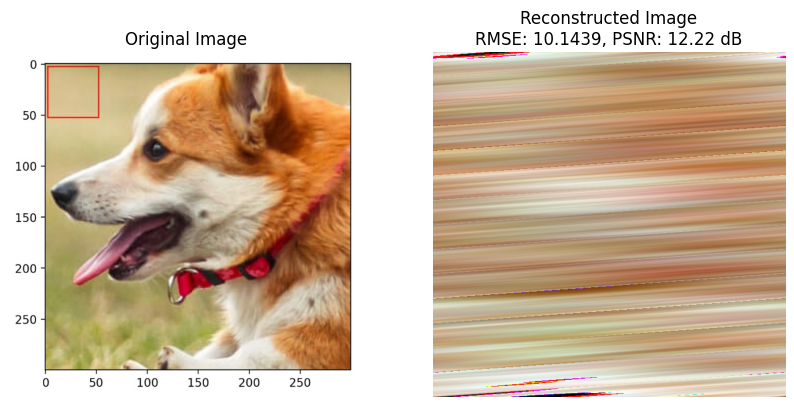

In [8]:
rmse_r = np.sqrt(mean_squared_error(image[:, :, 0], reconstructed_image[:, :, 0]))
rmse_g = np.sqrt(mean_squared_error(image[:, :, 1], reconstructed_image[:, :, 1]))
rmse_b = np.sqrt(mean_squared_error(image[:, :, 2], reconstructed_image[:, :, 2]))

rmse = np.mean([rmse_r, rmse_g, rmse_b])  
psnr_value = psnr(image, reconstructed_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title(f"Reconstructed Image\nRMSE: {rmse:.4f}, PSNR: {psnr_value:.2f} dB")
plt.axis('off')

plt.show()

In [9]:
%pip install sounddevice



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\rachi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.io import wavfile
import sounddevice as sd

In [11]:
samplerate, data = wavfile.read('file_example_WAV_1MG.wav')
duration = len(data) / samplerate
time = np.linspace(0., duration, len(data))

C:\Users\rachi\AppData\Local\Temp\ipykernel_10704\628830549.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read('file_example_WAV_1MG.wav')


In [12]:
data = data / np.max(np.abs(data))

def generate_rff(X, D=100, gamma=0.1):
    np.random.seed(42)
    W = np.random.randn(D) * np.sqrt(2 * gamma)
    b = 2 * np.pi * np.random.rand(D)
    Z = np.sqrt(2 / D) * np.cos(W * X[:, None] + b)
    return Z

rff_features = generate_rff(time, D=500, gamma=0.01)

In [13]:
model = LinearRegression()
model.fit(rff_features, data)

LinearRegression()

In [14]:
reconstructed_data = model.predict(rff_features)

In [15]:
rmse = np.sqrt(mean_squared_error(data, reconstructed_data))
snr = 10 * np.log10(np.sum(data ** 2) / np.sum((data - reconstructed_data) ** 2))

RMSE: 0.3856387199019036
SNR: 3.148246902953736e-06 dB


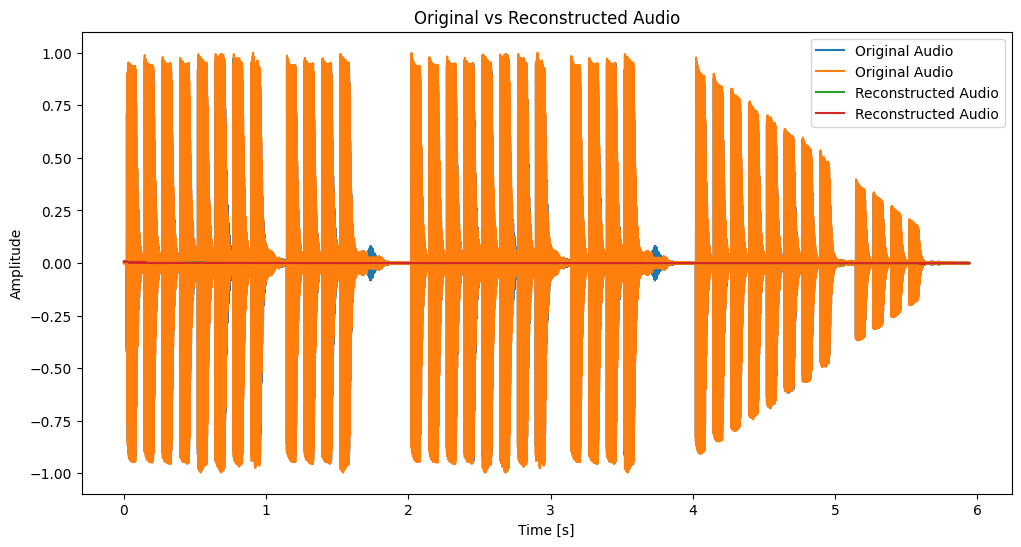

Playing original audio
Playing reconstructed audio


In [16]:
print(f"RMSE: {rmse}")
print(f"SNR: {snr} dB")

plt.figure(figsize=(12, 6))
plt.plot(time, data, label='Original Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed Audio')
plt.plot(time, reconstructed_data, label='Reconstructed Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.title('Original vs Reconstructed Audio')
plt.show()

sd.play(data, samplerate)
sd.wait()
print("Playing original audio")

sd.play(reconstructed_data, samplerate)
sd.wait()
print("Playing reconstructed audio")